In this notebook, we will test the VAE's capacity to learn the dependence structure between stocks on the stock market

In [87]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import ModelCheckpoint
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300 
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [67]:
# loading data
dataframe = pd.read_csv("10_Industry_Portfolios_Daily.csv", header=5)
dataframe = dataframe.iloc[0:26003, :]
dataframe.rename(columns={dataframe.columns[0]: "Date"}, inplace=True)
dataframe["Date"] = pd.to_datetime(dataframe["Date"], format="%Y%m%d")
dataframe.set_index("Date", inplace=True)

# convert to log losses
log_losses = -np.log1p(dataframe.astype(float)/100)

Text(0.5, 0.98, 'Plots of Log Losses')

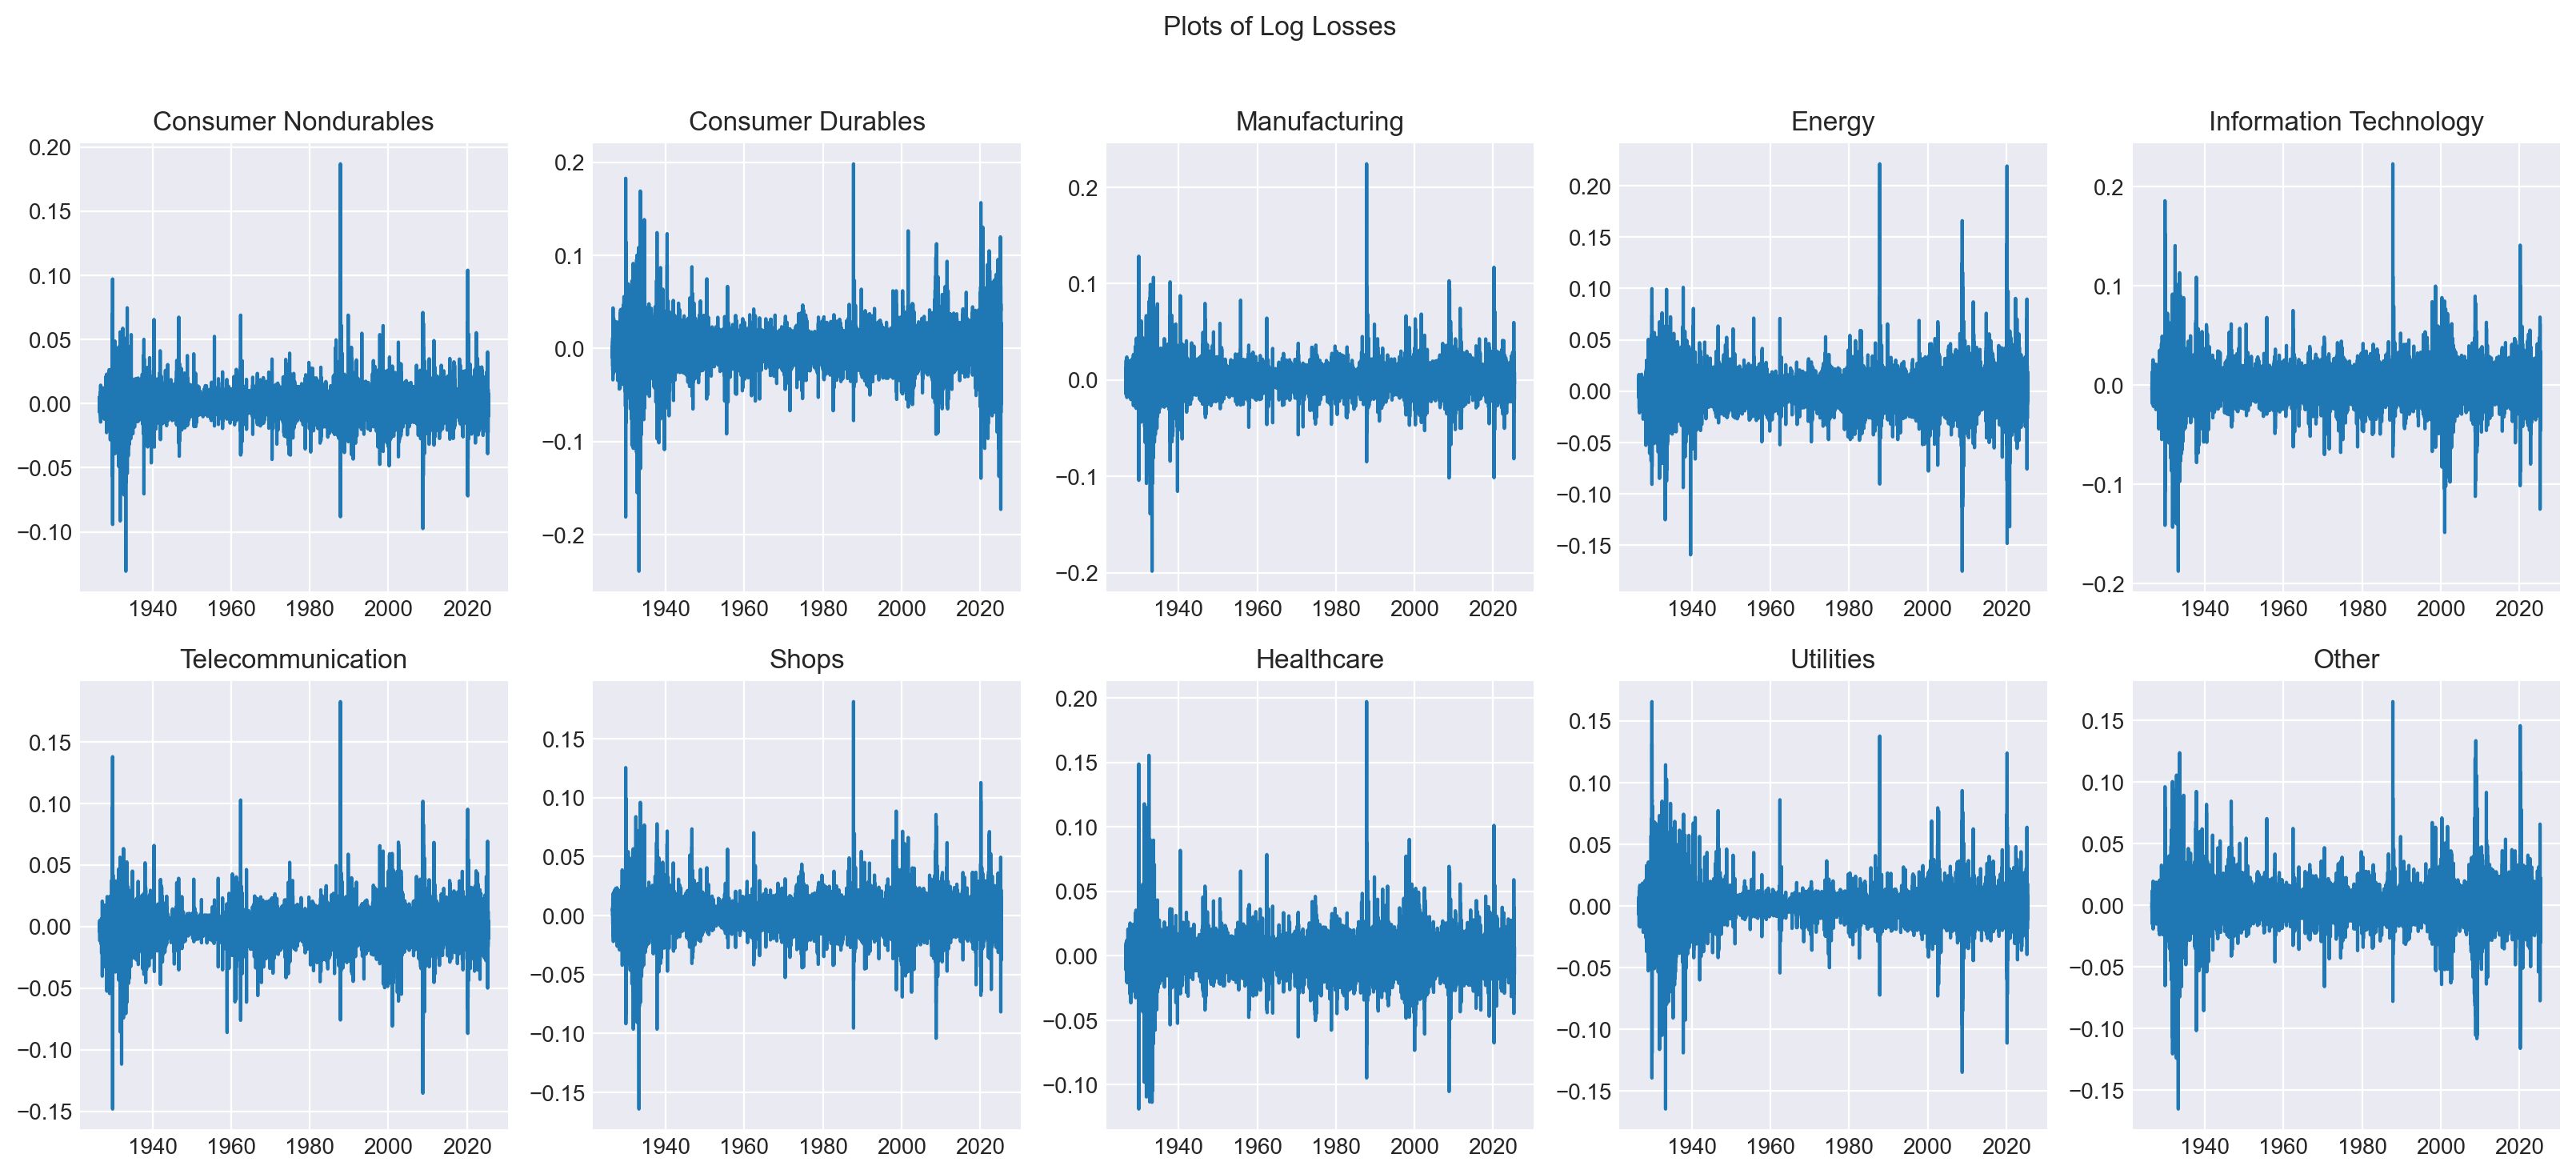

In [68]:
num_rows = 2
num_cols = 5
plt.style.use("seaborn-v0_8-darkgrid")
fig, axes = plt.subplots(num_rows,num_cols,figsize=(num_cols*4,num_rows*4), dpi=200)
axes[0,0].plot(log_losses.NoDur)
axes[0,0].set_title(f'Consumer Nondurables')
axes[0,1].plot(log_losses.Durbl)
axes[0,1].set_title(f'Consumer Durables')
axes[0,2].plot(log_losses.Manuf)
axes[0,2].set_title(f'Manufacturing')
axes[0,3].plot(log_losses.Enrgy)
axes[0,3].set_title(f'Energy')
axes[0,4].plot(log_losses.HiTec)
axes[0,4].set_title(f'Information Technology')

axes[1,0].plot(log_losses.Telcm)
axes[1,0].set_title(f'Telecommunication')
axes[1,1].plot(log_losses.Shops)
axes[1,1].set_title(f'Shops')
axes[1,2].plot(log_losses.Hlth)
axes[1,2].set_title(f'Healthcare')
axes[1,3].plot(log_losses.Utils)
axes[1,3].set_title(f'Utilities')
axes[1,4].plot(log_losses.Other)
axes[1,4].set_title(f'Other')

fig.suptitle("Plots of Log Losses")

Let's choose two pairs of sectors based on their expected degree of dependence and build our experiment based on those.
First pair: Consumer Durables (Durbl) and Manufacturing. I expect these to have a high degree of dependence since they sit on the same supply chain (the former is the output of the other). Both are driven by similar factors like consumer confidence, capital expenditure, interest and credit conditions. Moreover, when there are fluctuations in supply and demand on one end of the supply chain, they move to the other end and can even amplify, leading to joint extremes. 
Second pair: Utilities and Information Technology (HiTec). These may have a lower dependence since utilities are regulated and relatively stable businesses whereas information technology is a more dynamic and competitive sector.

We can somewhat get a sense of this by looking at their graphs side by side: we see that consumer durables and manufacturing experience extremes at the same time and even that fluctuations in durables are a positively scaled version of fluctuations in manufactutring.
On the other hand, we can see that utilities and information technology don't always experience simultaneous fluctuations and that they are less pronounced in the case of utilities due to the inherently more stable nature of that business sector.

Text(0.5, 0.98, 'Two pairs of market sectors with different dependence')

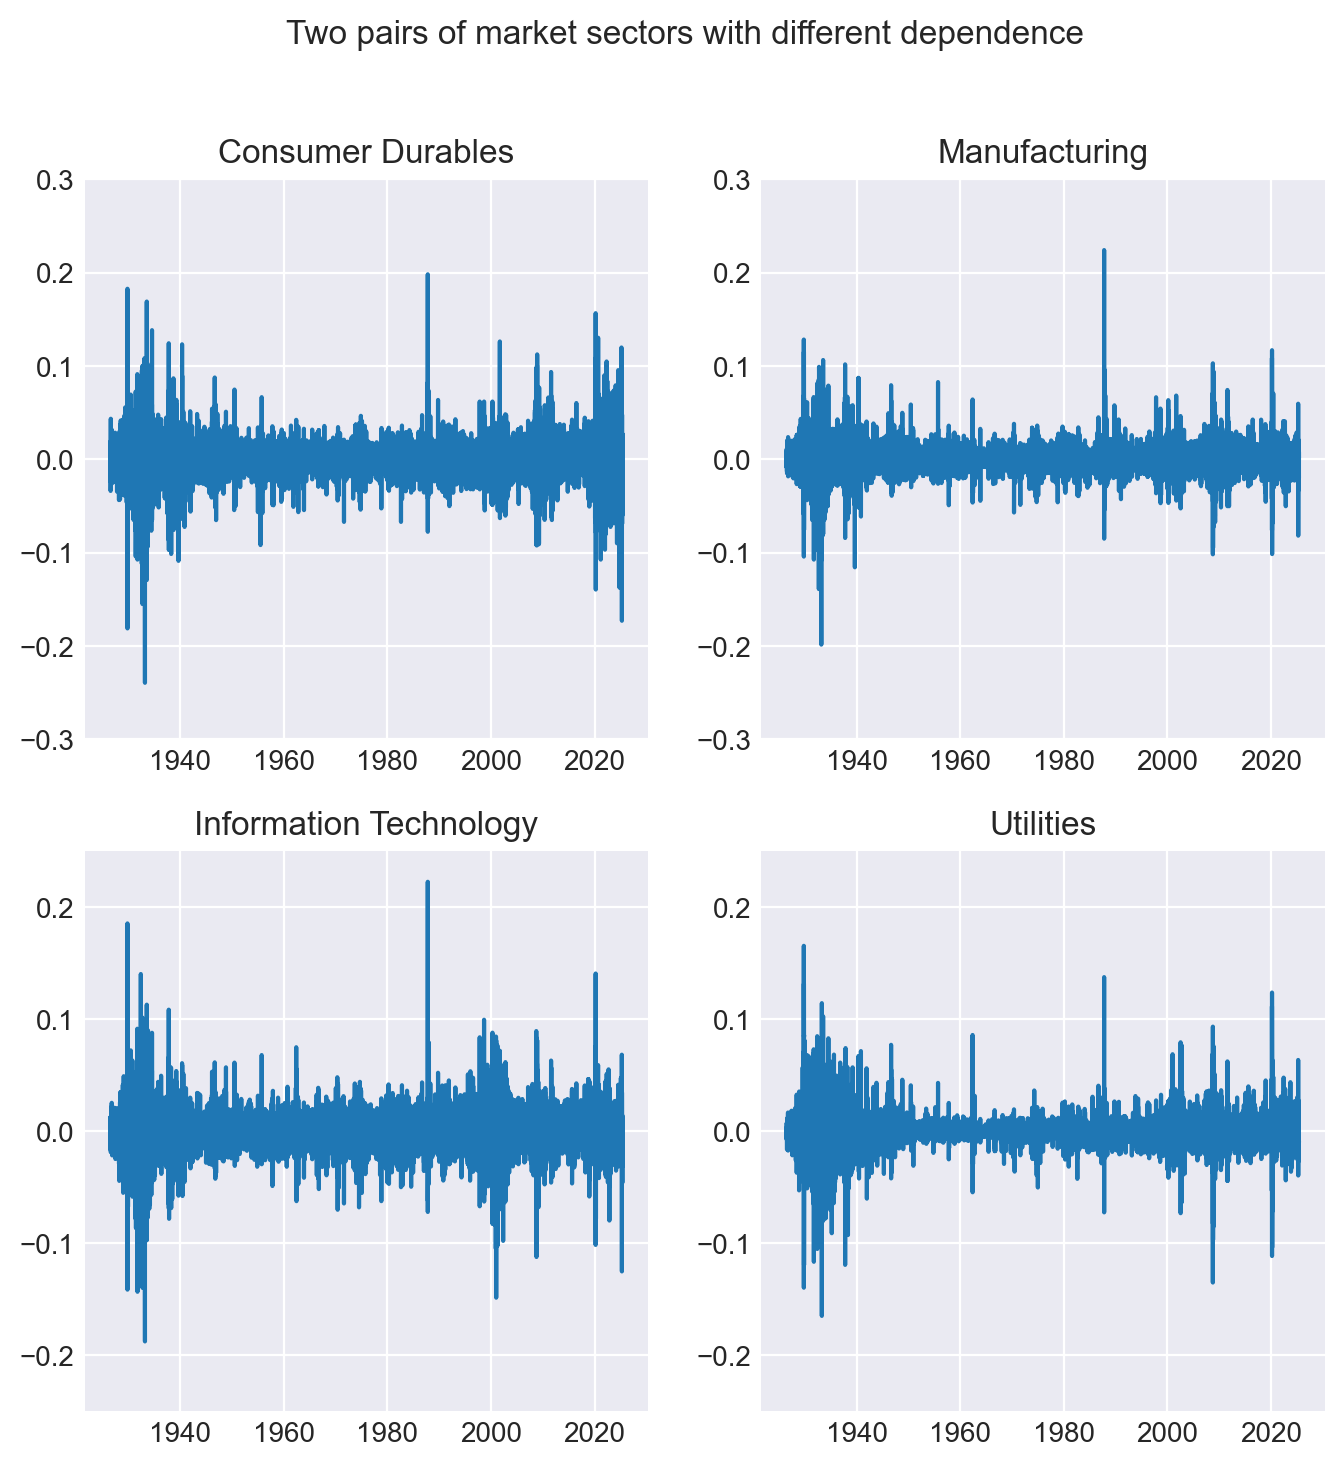

In [70]:
num_rows = 2
num_cols = 2
plt.style.use("seaborn-v0_8-darkgrid")
fig, axes = plt.subplots(num_rows,num_cols,figsize=(num_cols*4,num_rows*4), dpi=200)
axes[0,0].plot(log_losses.Durbl)
axes[0,0].set_ylim([-0.3,0.3])
axes[0,0].set_title("Consumer Durables")
axes[0,1].plot(log_losses.Manuf)
axes[0,1].set_ylim([-0.3,0.3])
axes[0,1].set_title("Manufacturing")
axes[1,0].plot(log_losses.HiTec)
axes[1,0].set_ylim([-0.25,0.25])
axes[1,0].set_title("Information Technology")
axes[1,1].plot(log_losses.Utils)
axes[1,1].set_ylim([-0.25,0.25])
axes[1,1].set_title("Utilities")
fig.suptitle("Two pairs of market sectors with different dependence")

We will fit our VAE model to quarterly block maxima and see how it models the dependence between the returns of these two pairs of sectors.

First, we get the block maxima

In [128]:
# more will be the observations for the pair with more dependence
qmax_nondur = log_losses.NoDur.resample('ME').max()#'QE-DEC').max()
qmax_manuf = log_losses.Manuf.resample('ME').max()#'QE-DEC').max()
more = np.array(pd.concat([qmax_nondur, qmax_manuf], axis=1))

# less will be the observations for the pair with more dependence
qmax_IT = log_losses.HiTec.resample('ME').max()#'QE-DEC').max()
qmax_utils = log_losses.Utils.resample('ME').max()#'QE-DEC').max()
less = np.array(pd.concat([qmax_IT, qmax_utils], axis=1))

Next, we get our copula-shaped data

Text(0.5, 1.0, 'Copula transform for less dependent data')

<Figure size 800x800 with 0 Axes>

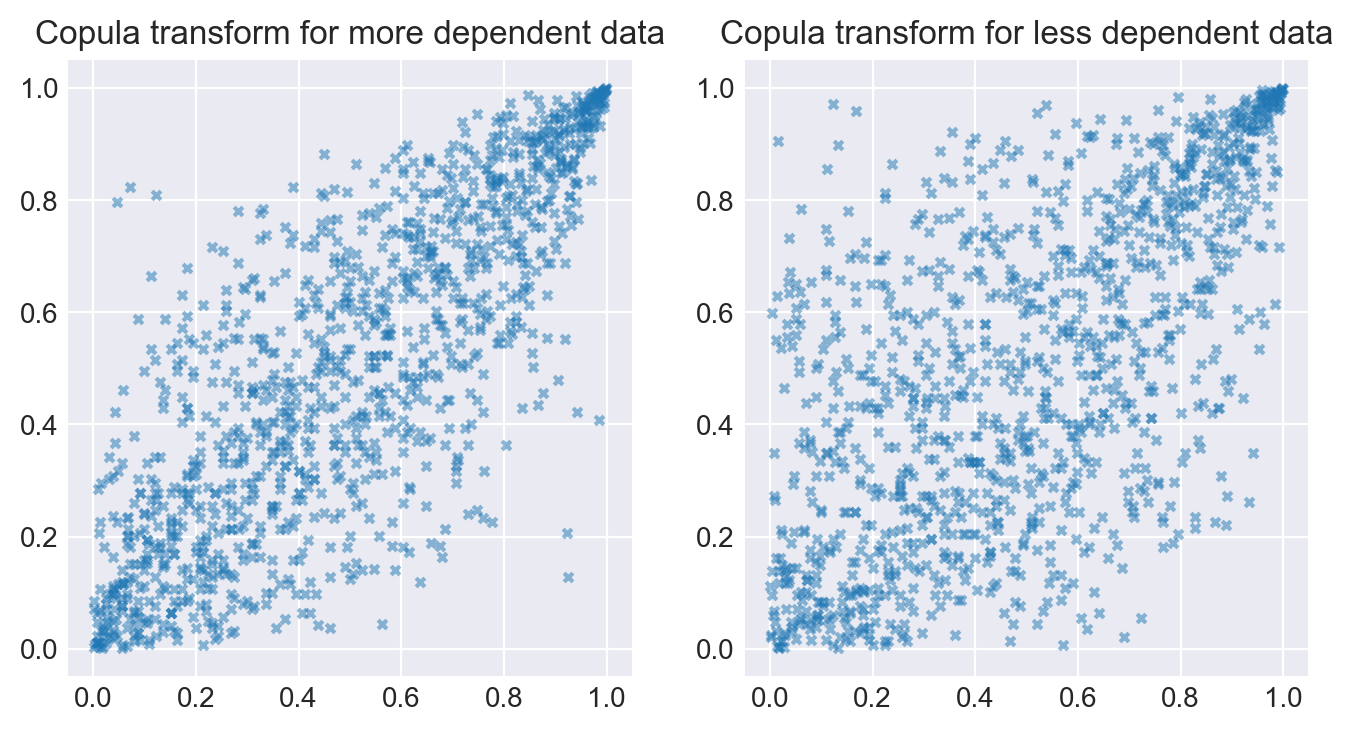

In [129]:
# for the more dependent pair
unif_more_1 = ECDF(more[:,0])(more[:,0])
unif_more_1 = unif_more_1 * len(unif_more_1)/(len(unif_more_1)+1)
unif_more_1 = unif_more_1[:, np.newaxis]

unif_more_2 = ECDF(more[:,1])(more[:,1])
unif_more_2 = unif_more_2 * len(unif_more_2)/(len(unif_more_2)+1)
unif_more_2 = unif_more_2[:, np.newaxis]

cop_more = np.concatenate((unif_more_1, unif_more_2), axis=1)

# for the less dependent pair
unif_less_1 = ECDF(less[:,0])(less[:,0])
unif_less_1 = unif_less_1 * len(unif_less_1)/(len(unif_less_1)+1)
unif_less_1 = unif_less_1[:, np.newaxis]

unif_less_2 = ECDF(less[:,1])(less[:,1])
unif_less_2 = unif_less_2 * len(unif_less_2)/(len(unif_less_2)+1)
unif_less_2 = unif_less_2[:, np.newaxis]

cop_less = np.concatenate((unif_less_1, unif_less_2), axis=1)

num_rows = 1
num_cols = 2
plt.style.use("seaborn-v0_8-darkgrid")
plt.figure(figsize=(4, 4), dpi=200)
fig, axes = plt.subplots(num_rows,num_cols,figsize=(num_cols*4,num_rows*4), dpi=200)
axes[0].scatter(cop_more[:,0], cop_more[:,1], marker="x", s=10, alpha=0.5)
axes[0].set_title("Copula transform for more dependent data")
axes[1].scatter(cop_less[:,0], cop_less[:,1], marker="x", s=10, alpha=0.5)
axes[1].set_title("Copula transform for less dependent data")

Very interesting: we do indeed see that the pair is slightly more dependent on the left-hand plot, as the point are more concentrated in the center and there is perhaps a slightly higher concentration of points in the upper righthand corner, indicating a slightly higher tendency to exhibit joint extremes.
Now, we shall see if our VAE can pick up on this.

We define our VAE class:

In [130]:
class Std_Encoder(tfk.Model): #Encodeur
    
    def __init__(self, num_neurons=100, kl_weight=0.1, activation='relu'):      
        super(Std_Encoder,self).__init__()
        self.encoded_size = 12 #taille de l'espace latent
        self.num_neurons = num_neurons
        self.kl_weight = kl_weight
        self.activation = activation
        self.prior        = tfd.MultivariateNormalDiag(loc=tf.zeros(self.encoded_size))
        self.dense1       = tfkl.Dense(self.num_neurons, activation=self.activation)
        #self.dense2       = tfkl.Dense(self.num_neurons, activation=self.activation)
        self.dense2       = tfkl.Dense(tfpl.IndependentNormal.params_size(self.encoded_size))
        self.ind_norm1    = tfpl.IndependentNormal(self.encoded_size,
                                                   activity_regularizer=tfpl.KLDivergenceRegularizer(self.prior,
                                                                                                     weight=self.kl_weight))
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        #x = self.dense3(x)
        x = self.ind_norm1(x)
        return x

class Std_Decoder(tfk.Model): #Décodeur
    def __init__(self, num_neurons=100, activation='relu'):
        super(Std_Decoder,self).__init__()
        self.K         = 2
        self.num_neurons = num_neurons
        self.activation = activation
        self.dense1    = tfkl.Dense(self.num_neurons, use_bias=True, activation=self.activation)
        #self.dense2    = tfkl.Dense(self.num_neurons, use_bias=True, activation=self.activation)
        self.dense2    = tfkl.Dense(tfpl.IndependentNormal(self.K).params_size(self.K))
        self.ind_norm1 = tfpl.IndependentNormal(self.K)
        
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        #x = self.dense3(x)
        x = self.ind_norm1(x)
        return x

class Std_VAE(tfk.Model):
    def __init__(self, num_neurons_encoder=100, num_neurons_decoder=100, kl_weight=0.1, activation='relu'):      
        super(Std_VAE,self).__init__()
        self.num_neurons_encoder = num_neurons_encoder
        self.num_neurons_decoder = num_neurons_decoder
        self.kl_weight=kl_weight
        self.activation = activation
        self.encoder = Std_Encoder(num_neurons=self.num_neurons_encoder, kl_weight=self.kl_weight, activation = self.activation)
        self.decoder = Std_Decoder(num_neurons=self.num_neurons_decoder, activation = self.activation)
    
    def call(self,inputs):
        return self.decoder(self.encoder(inputs))
    
    def generate_n_points(self, n):
        prior_points = self.encoder.prior.sample(n)
        gen_pre_transform = self.decoder(prior_points).sample()

        list_of_unifs = []
        for i in range(gen_pre_transform.shape[1]):
            unif = ECDF(np.array(gen_pre_transform[:,i]))(np.array(gen_pre_transform[:,i]))
            unif = unif * len(unif)/(len(unif)+1)
            unif = unif[:, np.newaxis]
            list_of_unifs.append(unif)

        frame = np.concatenate(tuple(list_of_unifs), axis=1)
        return frame

In [135]:
vae_more = Std_VAE(num_neurons_encoder=20, num_neurons_decoder=20, kl_weight=0.4, activation = 'sigmoid')
vae_more.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
        loss=negative_log_likelihood)
vae_more.fit(cop_more, cop_more, batch_size=8, epochs=200)

vae_less = Std_VAE(num_neurons_encoder=20, num_neurons_decoder=20, kl_weight=0.4, activation = 'sigmoid')
vae_less.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
        loss=negative_log_likelihood)
vae_less.fit(cop_less, cop_less, batch_size=8, epochs=200)

Epoch 1/200
149/149 [==============================] - 4s 3ms/step - loss: 1.6147
Epoch 2/200
149/149 [==============================] - 1s 3ms/step - loss: 0.5064
Epoch 3/200
149/149 [==============================] - 1s 6ms/step - loss: 0.4212
Epoch 4/200
149/149 [==============================] - 1s 3ms/step - loss: 0.4276
Epoch 5/200
149/149 [==============================] - 0s 3ms/step - loss: 0.3996
Epoch 6/200
149/149 [==============================] - 1s 6ms/step - loss: 0.3915
Epoch 7/200
149/149 [==============================] - 1s 4ms/step - loss: 0.3957
Epoch 8/200
149/149 [==============================] - 1s 5ms/step - loss: 0.3747
Epoch 9/200
149/149 [==============================] - 1s 5ms/step - loss: 0.3892
Epoch 10/200
149/149 [==============================] - 1s 3ms/step - loss: 0.3803
Epoch 11/200
149/149 [==============================] - 1s 4ms/step - loss: 0.3755
Epoch 12/200
149/149 [==============================] - 1s 4ms/step - loss: 0.3857
Epoch 13/200


Text(0.5, 1.0, 'Less dependent, simulated')

<Figure size 800x800 with 0 Axes>

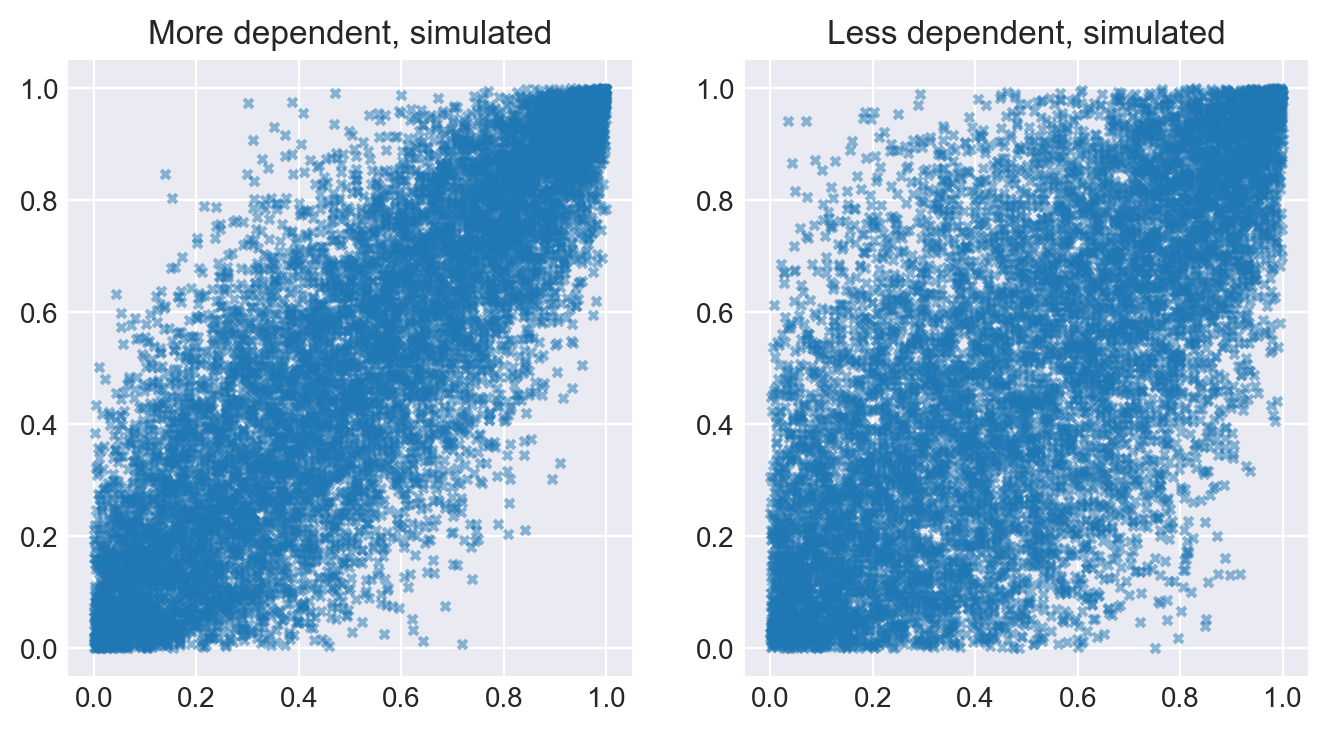

In [136]:
more_sim = vae_more.generate_n_points(10000)
less_sim = vae_less.generate_n_points(10000)

num_rows = 1
num_cols = 2
plt.style.use("seaborn-v0_8-darkgrid")
plt.figure(figsize=(4, 4), dpi=200)
fig, axes = plt.subplots(num_rows,num_cols,figsize=(num_cols*4,num_rows*4), dpi=200)
axes[0].scatter(more_sim[:,0], more_sim[:,1], marker="x", s=10, alpha=0.5)
axes[0].set_title("More dependent, simulated")
axes[1].scatter(less_sim[:,0], less_sim[:,1], marker="x", s=10, alpha=0.5)
axes[1].set_title("Less dependent, simulated")

Hurray, our VAE has learned on monthly maxima (quarterly was visibly not enough data)